# Проект: "Разработка системы рекомендаций банковских продуктов"
## Ноутбук для EDA и расчета рекомендаций
***

## Содержание
* [Инициализация](#step_0)
* [Подготовка инфраструктуры обучения моделей](#step_1)
* [Описание исходных данных](#step_2)
* [Анализ данных (EDA)](#step_3)
* [Расчет метрик](#step_4)
* [Обучение базовой модели](#step_5)
* [Отбор признаков](#step_6)
* [Подбор гиперпараметров](#step_7)

## Инициализация <a id="step_0"></a>

In [1]:
# Убедимся, что работаем в нужном окружении
import sys

print(sys.executable)

c:\Users\Kirill_Nosov\_Repos\.venv\Scripts\python.exe


In [1]:
# Импортируем необходимые библиотеки

import os
import gc
from dotenv import load_dotenv

import boto3
from botocore.exceptions import ClientError

import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_theme(style="whitegrid")

import joblib

#import scipy
from scipy.stats import pearsonr

from catboost import CatBoostClassifier, Pool
from category_encoders import CatBoostEncoder

from tqdm import tqdm
import datetime 

#import mlflow
#from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID

import sklearn.preprocessing
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder, 
    SplineTransformer, 
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
    FunctionTransformer
)

#from autofeat import AutoFeatRegressor

#from mlxtend.feature_selection import SequentialFeatureSelector as SFS
#from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

#import optuna
#from optuna.integration.mlflow import MLflowCallback

In [2]:
# Инциализируем генератор случайных чисел
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)

In [3]:
# Отключаем предупреждения
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning, FutureWarning))
#warnings.filterwarnings("ignore")

## Развертывание MLflow <a id="step_0"></a>

Для запуска MLflow нужно перейти на терминале в папку `/mlflow_server` и выполнить команду 

```sh run_mlflow_server.sh```

После этого устанавливаем параметры MLflow Tracking Server и MLflow Model Registry и задаем имя эксперимента (у нас будет один эксперимент на все этапы, которым будут соответствовать разные запуски).

In [ ]:
# Загружаем переменные окружения для S3-хранилища
load_dotenv()
os.environ["S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["S3_BUCKET_NAME"] = os.getenv("S3_BUCKET_NAME") 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

# Устанавливаем параметры MLflow
TRACKING_SERVER_HOST = '127.0.0.1' 
TRACKING_SERVER_PORT = 5000

tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_registry_uri(registry_uri) 

EXPERIMENT_NAME = 'mle-final-project'

## Описание исходных данных <a id="step_1"></a>

Файл [train_ver2.csv](https://disk.yandex.com/d/Io0siOESo2RAaA) содержит информацию о поведении 
клиентов банка за 1.5 года. 
Данные начинаются с 28.01.2015 и включают ежемесячные записи о продуктах, которые были у клиента, например, «кредитная карта», «сберегательный счет» и т.д. Необходимо предсказать, какие дополнительные продукты купит клиент в последнем месяце, оканчивающемся 28.06.2016, в дополнение к тому, что было у него 28.05.2016. 
Эти продукты представляют собой столбцы с именами ind_(xyz)_ult1, которые идут с 25-ой по 48-ю колонку в обучающих данных.

Список полей:
- fecha_dato - колонка для разделения таблицы,
- ncodpers - идентификатор пользователя,
- ind_empleado - статус занятости:
    - A — трудоустроен,
    - B — безработный (раньше работал),
    - F — иждивенец,
    - N — безработный,
    - P — пассивный (статус не определён),
- pais_residencia - страна проживания,
- sexo - пол, H - мужской, V - женский,
- age - возраст,
- fecha_alta - дата, когда клиент впервые заключил договор в банке,
- ind_nuevo - 1, если клиент зарегистрировался в течение последних 6 мес.,
- antiguedad - стаж клиента (в мес.),
- indrel:
    - 1 — основной клиент (т.е. основной владелец продукта - first/primary),
    - 99 — основной клиент в течение месяца, но не в последний день месяца,
- ult_fec_cli_1t - последняя дата, когда клиент был основным,
- indrel_1mes - тип клиента по отношению к продукту в начале месяца:
    - 1 — основной,
    - 2 — совладелец,
    - P — потенциальный,
    - 3 — бывший основной,
    - 4 — бывший совладелец,
- tiprel_1mes - тип клиента по отношению к банку в начале месяца:
    - A — активный,
    - I — неактивный,
    - P — бывший,
    - R — потенциальный,
- indresi - признак совпадения страны проживания клиента со страной банка, S - совпадает, N - не совпадает,
- indext - признак не совпадения страны рождения клиента со страной банка, S - не совпадает, N - совпадает,
- conyuemp - 1, если клиент является супругом(ой) работника банка,
- canal_entrada - канал, через который был привлечен клиент,
- indfall - признак актуальности счёта (англ. Deceased index, N/S),
- tipodom - тип адреса, 1 — основной адрес,
- cod_prov - код провинции (адреса клиента),
- nomprov - название провинции,
- ind_actividad_cliente - признак активности пользователя (1 — активный, 0 — неактивный),
- renta - валовый доход домохозяйства, 
- segmento - сегмент ('01 - TOP', '02 - PARTICULARES', '03 - UNIVERSITARIO'),

- ind_ahor_fin_ult1 - сберегательный счёт,
- ind_aval_fin_ult1 - банковская гарантия,
- ind_cco_fin_ult1 - текущие счета,
- ind_cder_fin_ult1 - деривативный счёт,
- ind_cno_fin_ult1 - зарплатный счет,
- ind_ctju_fin_ult1 - детский счёт,
- ind_ctma_fin_ult1 - особый счёт 3,
- ind_ctop_fin_ult1 - особый счёт,
- ind_ctpp_fin_ult1 - особый счёт 2,
- ind_deco_fin_ult1 - краткосрочный депозит,
- ind_deme_fin_ult1 - среднесрочный депозит,
- ind_dela_fin_ult1	- долгосрочный депозит,
- ind_ecue_fin_ult1	- цифровой счёт,
- ind_fond_fin_ult1	- фонды,
- ind_hip_fin_ult1 - ипотека,
- ind_plan_fin_ult1	- пенсионный план,
- ind_pres_fin_ult1	- кредит,
- ind_reca_fin_ult1	- налоговый счёт,
- ind_tjcr_fin_ult1	- кредитная карта,
- ind_valo_fin_ult1	- ценные бумаги,
- ind_viv_fin_ult1 - домашний счёт,
- ind_nomina_ult1 - зарплата,
- ind_nom_pens_ult1	- пенсии,
- ind_recibo_ult1 - прямой дебит

## Анализ данных (EDA) <a id="step_2"></a>

In [4]:
# Загружаем данные
data = pd.read_csv('../input_data/train_ver2.csv.zip')
data.head()

C:\Users\Kirill_Nosov\AppData\Local\Temp\ipykernel_9468\1194286340.py:2: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../input_data/train_ver2.csv.zip')


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


Из предупреждения *"DtypeWarning: Columns (5,8,11,15)"* следует, что значения в колонках 
- age, 
- antiguedad, 
- indrel_1mes,
- conyuemp

имеют разные типы внутри одной колонки, исправим это чуть позже.

In [5]:
# Исходные данные в транспонированном виде
data.head(5).T

,0,1,2,3,4
fecha_dato,2015-01-28,2015-01-28,2015-01-28,2015-01-28,2015-01-28
ncodpers,1375586,1050611,1050612,1050613,1050614
ind_empleado,N,N,N,N,N
pais_residencia,ES,ES,ES,ES,ES
sexo,H,V,V,H,V
age,35,23,23,22,23
fecha_alta,2015-01-12,2012-08-10,2012-08-10,2012-08-10,2012-08-10
ind_nuevo,0.0,0.0,0.0,0.0,0.0
antiguedad,6,35,35,35,35
indrel,1.0,1.0,1.0,1.0,1.0


Создаем список названий продуктов, словарь для их перевода на английский язык и 
список с временными отметками данных (fecha_dato)

In [5]:
# Список исходных целевых колонок
products_cols = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1',
               'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
               'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
               'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
               'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
               'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']

In [6]:
# Словарь для перевода продуктов на англ. яз.
products_map2eng = {
    "ind_ahor_fin_ult1" : "Saving Account",
    "ind_aval_fin_ult1" : "Guarantees",
    "ind_cco_fin_ult1" : "Current Accounts",
    "ind_cder_fin_ult1" : "Derivada Account",
    "ind_cno_fin_ult1" : "Payroll Account",
    "ind_ctju_fin_ult1" : "Junior Account",
    "ind_ctma_fin_ult1" : "Más Particular Account",
    "ind_ctop_fin_ult1" : "Particular Account",
    "ind_ctpp_fin_ult1" : "Particular Plus Account",
    "ind_deco_fin_ult1" : "Short-term Deposits",
    "ind_deme_fin_ult1" : "Medium-term Deposits",
    "ind_dela_fin_ult1" : "Long-term Deposits",
    "ind_ecue_fin_ult1" : "E-account",
    "ind_fond_fin_ult1" : "Funds",
    "ind_hip_fin_ult1" : "Mortgage",
    "ind_plan_fin_ult1" : "Plan Pensions",
    "ind_pres_fin_ult1" : "Loans",
    "ind_reca_fin_ult1" : "Taxes",
    "ind_tjcr_fin_ult1" : "Credit Card",
    "ind_valo_fin_ult1" : "Securities",
    "ind_viv_fin_ult1" : "Home Account",
    "ind_nomina_ult1" : "Payroll",
    "ind_nom_pens_ult1" : "Pensions",
    "ind_recibo_ult1" : "Direct Debit"
}

In [8]:
# Временные отметки данных
dataset_dates = sorted(data['fecha_dato'].unique().tolist())
dataset_dates

['2015-01-28',
 '2015-02-28',
 '2015-03-28',
 '2015-04-28',
 '2015-05-28',
 '2015-06-28',
 '2015-07-28',
 '2015-08-28',
 '2015-09-28',
 '2015-10-28',
 '2015-11-28',
 '2015-12-28',
 '2016-01-28',
 '2016-02-28',
 '2016-03-28',
 '2016-04-28',
 '2016-05-28']

In [4]:
# Проверяем типы колонок, кол-во строк и объем данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    object 
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             object 
 9   indrel                 float64
 10  ult_fec_cli_1t         object 
 11  indrel_1mes            object 
 12  tiprel_1mes            object 
 13  indresi                object 
 14  indext                 object 
 15  conyuemp               object 
 16  canal_entrada          object 
 17  indfall                object 
 18  tipodom                float64
 19  cod_prov               float64
 20  nomprov                object 
 21  ind_actividad_cliente  float64
 22  renta           

In [9]:
# Кол-во уникальных клиентов
data['ncodpers'].nunique()

956645

In [5]:
# Смотрим % пустых значений
data.isnull().mean() * 100

fecha_dato                0.000000
ncodpers                  0.000000
ind_empleado              0.203220
pais_residencia           0.203220
sexo                      0.203732
age                       0.000000
fecha_alta                0.203220
ind_nuevo                 0.203220
antiguedad                0.000000
indrel                    0.203220
ult_fec_cli_1t           99.818330
indrel_1mes               1.097513
tiprel_1mes               1.097513
indresi                   0.203220
indext                    0.203220
conyuemp                 99.986752
canal_entrada             1.363829
indfall                   0.203220
tipodom                   0.203227
cod_prov                  0.685784
nomprov                   0.685784
ind_actividad_cliente     0.203220
renta                    20.475648
segmento                  1.387585
ind_ahor_fin_ult1         0.000000
ind_aval_fin_ult1         0.000000
ind_cco_fin_ult1          0.000000
ind_cder_fin_ult1         0.000000
ind_cno_fin_ult1    

Из определения колонок cod_prov и nomprov следует, что они дублируют друг друга, поэтому одну из них можно удалить. Поскольку доля пустых значений у них одинаковая, то удалить можно любую. Удаляем cod_prov

In [10]:
# Удаляем колонку cod_prov
data.drop(columns=['cod_prov'], inplace=True)

In [11]:
# Удаляем признаковые колонки ult_fec_cli_1t и conyuemp, т.к. почти все значения в них пустые
data.drop(columns=['ult_fec_cli_1t','conyuemp'], inplace=True)

In [12]:
# Заполняем пропуски в двух целевых колонках ind_nomina_ult1 и ind_nom_pens_ult1 нулями и приводим их к целому типу
data['ind_nomina_ult1'] = data['ind_nomina_ult1'].fillna(0).astype(int)
data['ind_nom_pens_ult1'] = data['ind_nom_pens_ult1'].fillna(0).astype(int)

У целого ряда признаков имеется одинаковый процент пропусков: 0.20322%. Посмотрим соответствующие строки

In [8]:
data[data['ind_empleado'].isnull()][['ind_empleado', 
                                     'pais_residencia', 
                                     'sexo',
                                     'fecha_alta',
                                     'ind_nuevo',
                                     'indrel',
                                     'indresi',
                                     'indext',
                                     'indfall',
                                     'tipodom',
                                     'ind_actividad_cliente']]

,ind_empleado,pais_residencia,sexo,fecha_alta,ind_nuevo,indrel,indresi,indext,indfall,tipodom,ind_actividad_cliente
261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3775976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3776175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3776230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3776279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видим, что все эти признаки незаполнены у одних и тех же строк. Поскольку доля этих строк небольшая, 
а заполнение пустых значений обычными способами для некоторых признаков не имеет смысла (н-р, пол клиента
может быть заполнен в одном месяце, но не заполнен в другом, поэтому брать моду по всему датасету некорректно), 
то будет проще удалить эти строки

In [13]:
# Удаляем строки, у которых одновременно незаполнены все признаки, указанные выше
data.drop(data[data['ind_empleado'].isnull()].index, inplace=True)

В категориальной колонке indrel_1mes присутствуют как числа, так и строки, при этом она имеет тип object.
Проверим набор значений в этой колонке

In [14]:
# Значения в колонке indrel_1mes
data['indrel_1mes'].unique()

array([1.0, 3.0, 2.0, nan, '1.0', '1', '3', '3.0', '2.0', '4.0', 'P', '4',
       4.0, '2'], dtype=object)

Приводим значения в колонке indrel_1mes к одному типу и формату

In [15]:
# Заменяем на соответствующие строковые значения
data['indrel_1mes'].replace({1.0:'1', 
                             3.0:'3', 
                             2.0:'2', 
                             '1.0':'1', 
                             '3.0': '3', 
                             '2.0':'2', 
                             '4.0':'4', 
                             4.0:'4'}, inplace=True)

In [16]:
# Смотрим результат
data['indrel_1mes'].unique()

array(['1', '3', '2', nan, '4', 'P'], dtype=object)

Заполним пропуски в категориальных признаках. Сначала убедимся, что если у клиентов пропущены значения в каком-то одном месяце, то и во всех остальных записях у этих клиентов соответствующие признаки будут отсутствовать. 
Поэтому для заполнения таких пропусков можно использовать агрегированные статистики вместо данных по конкретному клиенту.

In [17]:
# Категориальные признаки с пропущенными значениями
categ_cols_with_nans = ['sexo', 
                        'indrel_1mes',
                        'tiprel_1mes',
                        'tipodom',
                        'canal_entrada',
                        'nomprov',
                        'segmento']

In [18]:
# Собираем id клиентов, у которых есть пропуски в соответствующих категориальных признаках
ncodpers_with_empty_categ_features = data[data[categ_cols_with_nans].isnull()]['ncodpers'].unique()

In [20]:
# Смотрим info по всем записям таких клиентов
data[data.ncodpers.isin(ncodpers_with_empty_categ_features)][categ_cols_with_nans].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sexo           0 non-null      object 
 1   indrel_1mes    0 non-null      object 
 2   tiprel_1mes    0 non-null      object 
 3   tipodom        0 non-null      float64
 4   canal_entrada  0 non-null      object 
 5   nomprov        0 non-null      object 
 6   segmento       0 non-null      object 
dtypes: float64(1), object(6)
memory usage: 0.0+ bytes


Видим, что непустых значений тоже нет, значит можно заполнять пропуски обычным способом, т.е.
брать, н-р, моды по всему датасету.

In [21]:
# Заполняем пропуски в оставшихся категориальных признаках
for col in categ_cols_with_nans:
    fill_value = data[col].mode().iloc[0]
    data[col].fillna(value=fill_value, inplace=True)

В датасете имеется 3 признака, которые являются числовыми по смыслу: age, antiguedad и renta.
При этом у колонок age и antiguedad указан тип object. Проверим значения в этих двух колонках

In [9]:
data['age'].unique()

array([' 35', ' 23', ' 22', ' 24', ' 65', ' 28', ' 25', ' 26', ' 53',
       ' 27', ' 32', ' 37', ' 31', ' 39', ' 63', ' 33', ' 55', ' 42',
       ' 58', ' 38', ' 50', ' 30', ' 45', ' 44', ' 36', ' 29', ' 60',
       ' 57', ' 67', ' 47', ' 34', ' 48', ' 46', ' 54', ' 84', ' 15',
       ' 12', '  8', '  6', ' 83', ' 40', ' 77', ' 69', ' 52', ' 59',
       ' 43', ' 10', '  9', ' 49', ' 41', ' 51', ' 78', ' 16', ' 11',
       ' 73', ' 62', ' 66', ' 17', ' 68', ' 82', ' 95', ' 96', ' 56',
       ' 61', ' 79', ' 72', ' 14', ' 19', ' 13', ' 86', ' 64', ' 20',
       ' 89', ' 71', '  7', ' 70', ' 74', ' 21', ' 18', ' 75', '  4',
       ' 80', ' 81', '  5', ' 76', ' 92', ' 93', ' 85', ' 91', ' 87',
       ' 90', ' 94', ' 99', ' 98', ' 88', ' 97', '100', '101', '106',
       '103', '  3', '  2', '102', '104', '111', '107', '109', '105',
       '112', '115', '110', '116', '108', '113', 37, 81, 43, 30, 45, 41,
       67, 59, 46, 36, 47, 69, 39, 44, 40, 38, 34, 42, 31, 35, 48, 60, 54,
       51, 3

In [10]:
data['antiguedad'].unique()

array(['      6', '     35', '     34', '     33', '     31', '     21',
       '     16', '     27', '      9', '     22', '     13', '     29',
       '      8', '     11', '     10', '     28', '     24', '      7',
       '     25', '     14', '     26', '     12', '     23', '      1',
       '     18', '      4', '      3', '     17', '     32', '     30',
       '     20', '     15', '     19', '    157', '     36', '      5',
       '     40', '     38', '     37', '     39', '      0', '      2',
       '     47', '     44', '     42', '     46', '     45', '     43',
       '     41', '     57', '     48', '     52', '     49', '     50',
       '     56', '     58', '     51', '     55', '     54', '     53',
       '     59', '     62', '     61', '     60', '     63', '    139',
       '    165', '    118', '    164', '    142', '     94', '    159',
       '    143', '    105', '    151', '    162', '    137', '    150',
       '    128', '    122', '    156', '    119', 

Пропусков нет, но есть строковые и экстремальные значения. Приводим строковые значения их к числовому типу, 
выбросы удалим чуть позже

In [22]:
# Приводим age и antiguedad к float
data['age'] = data['age'].astype('float64')
data['antiguedad'] = data['antiguedad'].astype('float64')

Заполним пропуски в renta. Аналогично категориальным признакам выше, легко проверить, что
для заполнения renta можно брать агрегированные статистики вместо данных по конкретному клиенту

In [23]:
# Берем id клиентов, у которых есть пропуски в renta
ncodpers_with_empty_renta = data[data.renta.isnull()]['ncodpers'].unique()

In [24]:
# Смотрим info по всем записям таких клиентов
data[data.ncodpers.isin(ncodpers_with_empty_renta)]['renta'].info() 

<class 'pandas.core.series.Series'>
Index: 2766641 entries, 4 to 13647308
Series name: renta
Non-Null Count  Dtype  
--------------  -----  
0 non-null      float64
dtypes: float64(1)
memory usage: 42.2 MB


Видим, что все renta у таких клиентов действительно пустые, поэтому для заполнения пропусков можно использовать данные по датасету. При этом необходимо учитывать возможные выбросы и разброс по регионам. 
Как показано на рисунках ниже, и то, и другое действительно имеют место

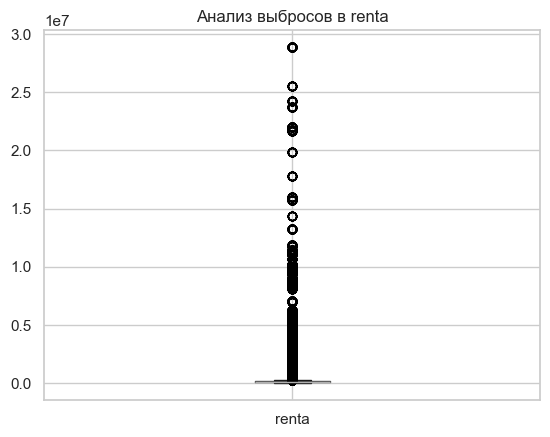

In [37]:
# Строим boxplot для renta
plt.figure(figsize=(8,4))
data[['renta']].boxplot()
plt.title('Boxplot для renta')
plt.show()

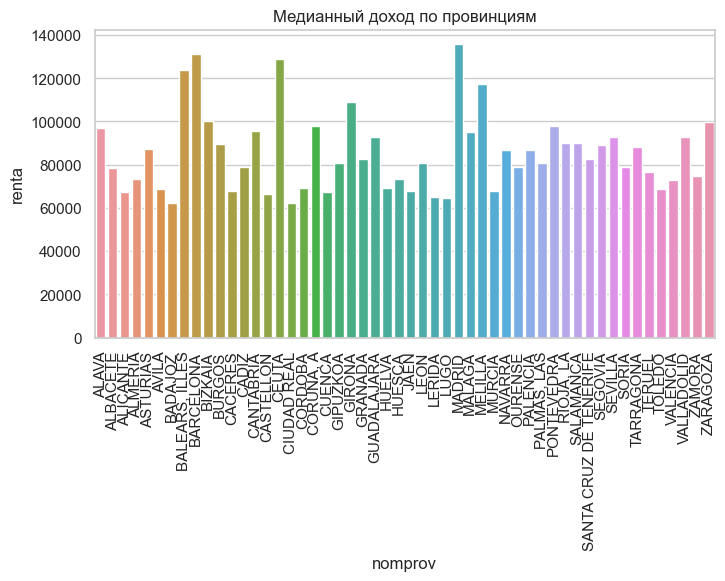

In [64]:
# Медианные доходы в разрезе провинций
plt.figure(figsize=(8,4))
agg_by_prov = pd.DataFrame(data.groupby("nomprov")["renta"].agg('median')).reset_index() 
sns.barplot(data=agg_by_prov, x='nomprov', y='renta') 
plt.title(f'Медианный доход по провинциям')
plt.xticks(rotation='vertical')
plt.show()

Видим, что у renta есть экстремальные значения и разброс по провинциям.
Чтобы решить, являются ли большие renta выбросами или же они относятся к премиальному сегменту,
посмотрим максимумы в имеющиxя клиентских сегментах

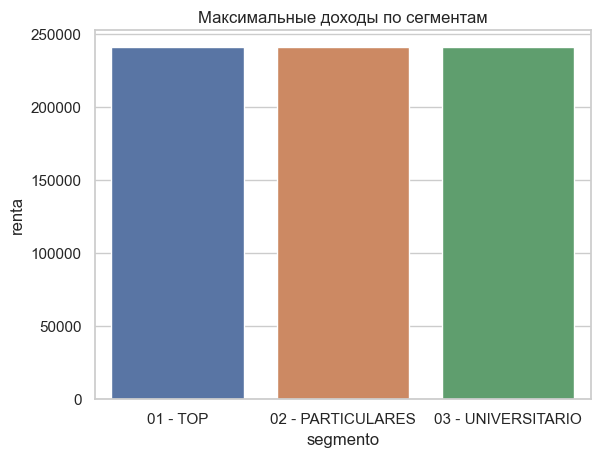

In [63]:
# Максимальные доходы по сегментам
plt.figure(figsize=(8,4))
agg_by_segm = pd.DataFrame(data.groupby("segmento")["renta"].agg('max')).reset_index() 
sns.barplot(data=agg_by_segm, x='segmento', y='renta') 
plt.title(f'Максимальные доходы по сегментам')
plt.show()

Видим противоречие, т.к. максимальные доходы в топ-сегменте оказались самыми низкими.
Поэтому экстремальные значения в renta можно считать выбросами и удалить, 
а для заполнения пропусков в renta будем использовать медианы в соответствующих провинциях

In [40]:
# Заполняем пропуски в renta медианами в соответствующих провинциях
agg_by_prov = pd.DataFrame(data.groupby("nomprov")["renta"].agg('median'))

for prov in data['nomprov'].unique():
    selected_raws = (data['nomprov'] == prov)
    fill_value = agg_by_prov.loc[prov, 'renta']
    data.loc[selected_raws, 'renta'] = data.loc[selected_raws, 'renta'].fillna(value=fill_value)

Удаляем выбросы у количественных признаков

In [47]:
# Количественные признаки
num_cols = ['age', 'antiguedad', 'renta']

threshold = 1.5
outliers = pd.DataFrame()

for col in num_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    margin = threshold * IQR
    lower = Q1 - margin
    upper = Q3 + margin
    outliers[col] = ~data[col].between(lower, upper)
    
outliers = outliers[['age', 'antiguedad', 'renta']].any(axis=1)
data = data[~outliers]

Оценим динамику активности клиентов, чтобы выявить возможную сезонность в их поведении
и соответственно оставить только те данные, которые релевантны для целевой прогнозной даты (конец июня 2016 г.).
Для этого оставим только "старых" клиентов, заключивших свой первый контракт до 01.01.2015, чтобы исключить вклад новых клиентов

In [55]:
# Оставляем только "старых" клиентов
old_clients_data = data.query("fecha_alta < '2025-01-01'")

In [77]:
# Добавляем колонку с количеством продуктов в каждой записи
old_clients_data['products_cnt_per_rec'] = old_clients_data[products_cols].sum(axis=1)
#data['products_cnt_per_rec'] = data[products_cols].sum(axis=1)

In [83]:
agg_by_date

,fecha_dato,total_products_cnt
0,2015-01-28,991532
1,2015-02-28,996110
2,2015-03-28,1003086
3,2015-04-28,1009321
4,2015-05-28,1006139
5,2015-06-28,1018493
6,2015-07-28,1034595
7,2015-08-28,1038979
8,2015-09-28,1060119
9,2015-10-28,1084115


In [86]:
agg_by_date["lag1"] = agg_by_date.total_products_cnt.shift(1)
agg_by_date["added_prods"] = agg_by_date['total_products_cnt'] - agg_by_date['lag1']
agg_by_date

,fecha_dato,total_products_cnt,lag1,added_prods
0,2015-01-28,991532,NaN,NaN
1,2015-02-28,996110,991532.0,4578.0
2,2015-03-28,1003086,996110.0,6976.0
3,2015-04-28,1009321,1003086.0,6235.0
4,2015-05-28,1006139,1009321.0,-3182.0
5,2015-06-28,1018493,1006139.0,12354.0
6,2015-07-28,1034595,1018493.0,16102.0
7,2015-08-28,1038979,1034595.0,4384.0
8,2015-09-28,1060119,1038979.0,21140.0
9,2015-10-28,1084115,1060119.0,23996.0


In [78]:
# Агрегируем кол-во продуктов по месяцам
agg_by_date = old_clients_data.groupby("fecha_dato")\
    .agg(total_products_cnt=('products_cnt_per_rec', 'sum')).reset_index()
'''
agg_by_date = data.groupby("fecha_dato")\
    .agg(total_products_cnt=('products_cnt_per_rec', 'sum')).reset_index()
'''

'\nagg_by_date = data.groupby("fecha_dato")    .agg(total_products_cnt=(\'products_cnt_per_rec\', \'sum\')).reset_index()\n'

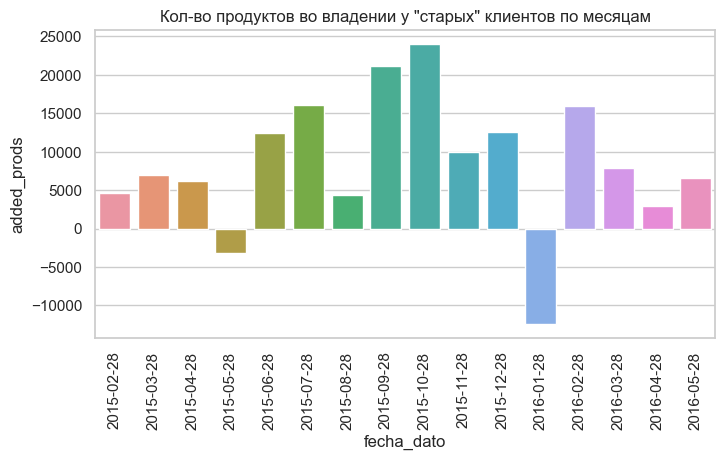

In [88]:
# Строим барплот 

plt.figure(figsize=(8,4))
sns.barplot(data=agg_by_date.iloc[1:,:], x='fecha_dato', y='added_prods')\
    .set_title('Кол-во продуктов во владении у "старых" клиентов по месяцам')
plt.xticks(rotation='vertical')
plt.show()

Видим, что наблюдаются полугодовые изменения в характере поведения клиентов, 
поэтому имеет смысл оставить только данные, соответствующие первым полугодиям

In [21]:
# Оставляем данные, начиная с ноября 2015 г.
data = data.query("fecha_alta >= '2015-07-28'")

In [ ]:
#WIP

In [89]:
# Смотрим, какого размера получились данные после удаления части строк
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12506907 entries, 0 to 13647308
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    float64
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             float64
 9   indrel                 float64
 10  indrel_1mes            object 
 11  tiprel_1mes            object 
 12  indresi                object 
 13  indext                 object 
 14  canal_entrada          object 
 15  indfall                object 
 16  tipodom                float64
 17  nomprov                object 
 18  ind_actividad_cliente  float64
 19  renta                  float64
 20  segmento               object 
 21  ind_ahor_fin_ult1      int64  
 22  ind_aval_fin_ult1    

In [18]:
# Кол-во уникальных клиентов
data['ncodpers'].nunique()

942289

Выделим отдельно бинарные и небинарные категориальные признаки, чтобы потом применять
к ним отдельные энкодеры

In [91]:
# Бинарные категориальные признаки
bin_cat_cols = ['sexo', 
                'ind_nuevo', 
                'indresi', 
                'indrel',
                'indext', 
                'indfall', 
                'tipodom', 
                'ind_actividad_cliente']

# Небинарные категориальные признаки
non_bin_cat_cols = ['ind_empleado', 
                    'pais_residencia',
                    'indrel_1mes',
                    'tiprel_1mes',
                    'canal_entrada',
                    'cod_prov',
                    'segmento']

Убедимся, что у бинарных признаков имеется по 2 различных значения 

In [92]:
data[bin_cat_cols].nunique()

sexo                     2
ind_nuevo                2
indresi                  2
indrel                   2
indext                   2
indfall                  2
tipodom                  1
ind_actividad_cliente    2
dtype: int64

Видим, что признак tipodom является константным, поэтому его можно удалить 

In [27]:
data.drop(columns=['tipodom'], inplace=True)

In [100]:
data['indfall'].value_counts()

indfall
N    12485227
S       21680
Name: count, dtype: int64

Переходим к целевым переменным.

In [21]:
# Список исходных целевых колонок
target_cols = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1',
               'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
               'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
               'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
               'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
               'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']

Оценим, сколько продуктов одновременно бывает у клиентов 

In [ ]:
# Просуммируем целевые переменные по горизонтали, чтобы оценить общее кол-во продуктов у каждого клиента
targets_sums_horiz = data.iloc[:, 22:].sum(axis=1)
targets_sums_horiz.unique()

In [ ]:
# Строим гистограмму распределения кол-ва продуктов у клиентов
plt.hist(targets_sums_horiz)
plt.title("Распределение кол-ва продуктов у клиентов")
plt.show()

Т.е. в основном клиенты пользуются одним продуктом, но встречаются и случаи с 2-8. 

Перейдем к одной целевой переменной, т.е. заменим задачу классификации с Multi-Class на Multi-Label. Для этого конкатенируем исходные целевые столбцы и закодируем получившиеся последовательности из 1 и 0 

In [ ]:
# Приводим значения 1/0 в исходных целевых колонках к строковому типу
data[target_cols] = data[target_cols].astype(str)

In [ ]:
# Конкатенируем исходные целевые колонки в новую колонку 
data['target'] = data[target_cols].agg(''.join, axis=1)

In [ ]:
# Смотрим, что получилось
data['target']

In [ ]:
# Кол-во уникальных таргетов
data['target'].nunique()

Оценим популярность продуктов для генерации рекомендаций по умолчанию. Для этого сначала разобьем датасет на train и test, где test будет содержать данные за последний месяц, т.е. за май 2016 г.

In [31]:
# Разделяем датасет на train и test
train_test_split_idx = data["fecha_dato"] <= "2016-04-28"
data_train = data[train_test_split_idx]
data_test = [~train_test_split_idx]

In [47]:
# Просуммируем целевые переменные по вертикали, чтобы оценить популярность продуктов
items = data_train.iloc[:, 21:].sum(axis=0)
items.sort_values(inplace=True, ascending=False)

In [48]:
# Формируем таблицу продуктов, отсортированных по встречаемости в train
items = pd.DataFrame(items)\
    .reset_index()\
        .rename(columns={'index': 'name'})\
            .rename(columns={0: 'clients'})\
                .reset_index()\
                    .rename(columns={'index': 'rank'})\
                        .reset_index()\
                            .rename(columns={'index': 'item_id'})

items['rank'] += 1
items

,item_id,rank,name,events_cnt
0,0,1,ind_cco_fin_ult1,5413699
1,1,2,ind_recibo_ult1,1049140
2,2,3,ind_ctop_fin_ult1,1001428
3,3,4,ind_ecue_fin_ult1,675684
4,4,5,ind_cno_fin_ult1,663556
5,5,6,ind_nom_pens_ult1,486672
6,6,7,ind_nomina_ult1,447491
7,7,8,ind_reca_fin_ult1,431700
8,8,9,ind_tjcr_fin_ult1,357306
9,9,10,ind_ctpp_fin_ult1,340643


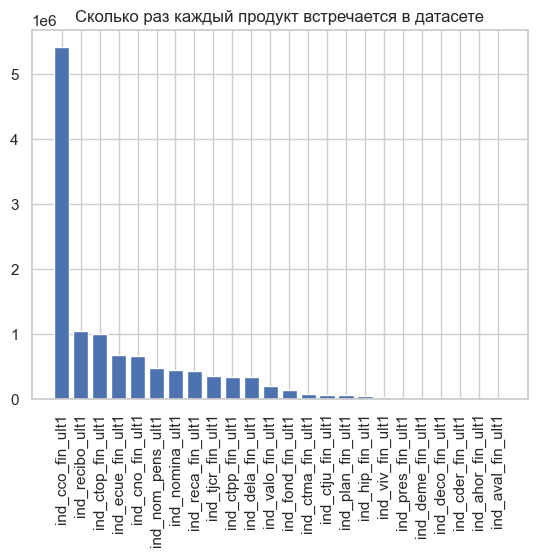

In [45]:
# Строим гистограмму встречаемости продуктов во всем датасете
plt.bar(items.name, items.events_cnt)
plt.xticks(rotation='vertical')
plt.title("Сколько раз каждый продукт встречается в датасете")
plt.show()

Таким образом, текущие счета являются наиболее популярными. Сохраняем эти данные в файл

In [50]:
items.to_parquet('../data/items.parquet')

Переименовываем очищенный датасет в events и сохраняем его в отдельном файле

In [25]:
events = data
events.to_parquet("../data/events.parquet")

### Выводы по этапу EDA

- Удалили признак nomprov, т.к. он дублирует cod_prov; 
- Проверили исходные данные на наличие пропусков, некорректных типов и  
значений:
    - Удалили признаки ult_fec_cli_1t и conyuemp, т.к. у них почти 100% пропусков;
    - В двух целевых колонках (ind_nomina_ult1 и ind_nom_pens_ult1) заполнили пропуски нулями 
    и привели их к целому типу;
    - В признаке indrel_1mes привели значения к одному типу и формату;
    - Удалили строки, в которых одновременно незаполнены 11 признаков;
    - Строковые значения у числовых признаков и сами эти признаки привели к типу float;
    - Пропуски у числовых признаков заполнили средними значениями,
    у категориальных - модами. При этом убедились, что взятие этих статистик по всему 
    датасету корректно, т.к. если данные признаки незаполнены в одном месяце, 
    то их нет и в остальных записях соответствующих клиентов;
- Удалили выбросы у числовых признаков age и antiguedad, большие значения у renta
решили оставить, т.к. они встречаются у значительного количества клиентов, и, скорее всего,
соответствуют премиальному сегменту;
- Обнаружили изменения в характере распределения количества клиентов по времени,
поэтому оставили только данные с июля 2017, что позволило также
сократить датасет с ~5Gb до ~3.3Gb;
- Проанализировали популярность продуктов (самым популярными оказались текущие счета), соответствующие данные
сохранили в файле `data/items.parquet` для формирования рекомендаций по умолчанию;
- Очищенные данные сохранили в файле `data/events.parquet`

## Расчет метрик <a id="step_0"></a>

In [ ]:
# referring to https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

def apk(actual, predicted, k=7):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)


def mapk(actual, predicted, k=7):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])